<a href="https://colab.research.google.com/github/Mihishi/ECG-image-classification/blob/main/ecg_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your zipped dataset on Google Drive
# Assuming the 'image-processing.zip' file is in the root of your Drive for simplicity.
# Adjust the folder if it's nested (e.g., /content/drive/MyDrive/MyFolder/image-processing.zip)
GDRIVE_ZIP_PATH = "/content/drive/MyDrive/Mihishi/FYP-Project-Proposal/image-processing.zip"

# Define the local directory where the data will be extracted
LOCAL_DATA_DIR = "/content/extracted_data/"



# Create the local directory
!mkdir -p {LOCAL_DATA_DIR}

# Check if the zip file exists on Drive before attempting to copy
if os.path.exists(GDRIVE_ZIP_PATH):
    print(f"Copying {GDRIVE_ZIP_PATH} to local storage...")

    # Copy the zip file
    !cp "{GDRIVE_ZIP_PATH}" /content/

    # Unzip the file into the designated local directory
    ZIP_NAME = os.path.basename(GDRIVE_ZIP_PATH)
    !unzip -q "/content/{ZIP_NAME}" -d {LOCAL_DATA_DIR}
    print(f"Dataset extracted to {LOCAL_DATA_DIR}")

    # Clean up - remove the zip file from local storage to save disk space
    !rm "/content/{ZIP_NAME}"
else:
    print(f"Error: Zip file not found at {GDRIVE_ZIP_PATH}. Please ensure the file is named 'image-processing.zip' and is in the root of your Google Drive.")



# Update the path to point to the 'train' folder inside the unzipped structure
# LOCAL_DATA_DIR (from above) + ECG_DATA/train
data_path = "/content/extracted_data/ECG_DATA/train"

images = []
labels = []

# Verify that the final path exists
if not os.path.isdir(data_path):
    print(f"Error: Final data path not found: {data_path}. Check your zip's internal structure.")
else:
    # List all subfolders (these are your class labels)
    for subfolder in os.listdir(data_path):

        subfolder_path = os.path.join(data_path, subfolder)

        # Ensure it's a directory before proceeding
        if not os.path.isdir(subfolder_path):
            continue

        # List all image files within the class subfolder
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder) # The subfolder name is the label

    data = pd.DataFrame({'image': images, 'label': labels})

    print("Data loading successful!")
    print(f"Total images found: {len(data)}")
    print("\nSample Data:")
    print(data.head())

Mounted at /content/drive
Copying /content/drive/MyDrive/Mihishi/FYP-Project-Proposal/image-processing.zip to local storage...
Dataset extracted to /content/extracted_data/
Data loading successful!
Total images found: 3023

Sample Data:
                                               image  \
0  /content/extracted_data/ECG_DATA/train/ECG Ima...   
1  /content/extracted_data/ECG_DATA/train/ECG Ima...   
2  /content/extracted_data/ECG_DATA/train/ECG Ima...   
3  /content/extracted_data/ECG_DATA/train/ECG Ima...   
4  /content/extracted_data/ECG_DATA/train/ECG Ima...   

                                               label  
0  ECG Images of Myocardial Infarction Patients (...  
1  ECG Images of Myocardial Infarction Patients (...  
2  ECG Images of Myocardial Infarction Patients (...  
3  ECG Images of Myocardial Infarction Patients (...  
4  ECG Images of Myocardial Infarction Patients (...  


In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (2418, 2)
Validation set shape: (302, 2)
Test set shape: (303, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    cval=0,
)

ts_gen = ImageDataGenerator()


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 2418 validated image filenames belonging to 4 classes.
Found 302 validated image filenames belonging to 4 classes.
Found 303 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

class StopAt98Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.98 or logs.get('val_accuracy') >= 0.98:
            acc_type = "TRAINING" if logs.get('accuracy') >= 0.98 else "VALIDATION"
            print(f"\nReached 98% {acc_type} accuracy at epoch {epoch+1}. Stopping training!")
            self.model.stop_training = True

def build_improved_model(base_model, num_classes=4):
    base_model.trainable = True

    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

callbacks = [
    StopAt98Accuracy(),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

In [ ]:
input_shape = (100, 100, 3)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg16_improved = build_improved_model(base_model, num_classes=4)

history = model_vgg16_improved.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=callbacks
)

accuracy_vgg16_improved = model_vgg16_improved.evaluate(valid_gen)[1]
print(f"Improved VGG16 Accuracy: {accuracy_vgg16_improved:.4f}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 84s 922ms/step - accuracy: 0.2868 - loss: 1.5092 - val_accuracy: 0.2318 - val_loss: 4.0794 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 751ms/step - accuracy: 0.4067 - loss: 1.2355 - val_accuracy: 0.2318 - val_loss: 8.5643 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 815ms/step - accuracy: 0.4729 - loss: 1.1151 - val_accuracy: 0.2252 - val_loss: 4.3132 - learning_rate: 1.0000e-04
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 747ms/step - accuracy: 0.5482 - loss: 1.0280 - val_accuracy: 0.3974 - val_loss: 1.4664 - learning_rate: 1.0000e-04
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 766ms/step - accuracy: 0.6081 - loss: 0.9502 - val_accuracy: 0.6755 - val_loss: 0.8224 - learning_rate: 1.0000e-04
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 756ms/step - accuracy: 0.6695 - loss: 0.8477 - val_accuracy: 0.5000 - val_loss: 2.4810 - learning_rate: 1.0000e-04
Epoch 7


Generating predictions for classification report and confusion matrix...

CLASSIFICATION REPORT
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)     0.7750    0.6526    0.7086        95
     ECG Images of Patient that have History of MI (172x12=2064)     0.5000    0.6731    0.5738        52
ECG Images of Patient that have abnormal heartbeat (233x12=2796)     0.9211    0.5000    0.6481        70
                          Normal Person ECG Images (284x12=3408)     0.6316    0.8471    0.7236        85

                                                        accuracy                         0.6755       302
                                                       macro avg     0.7069    0.6682    0.6635       302
                                                    weighted avg     0.7211    0.6755    0.6756       302


CONFUSION MATRIX


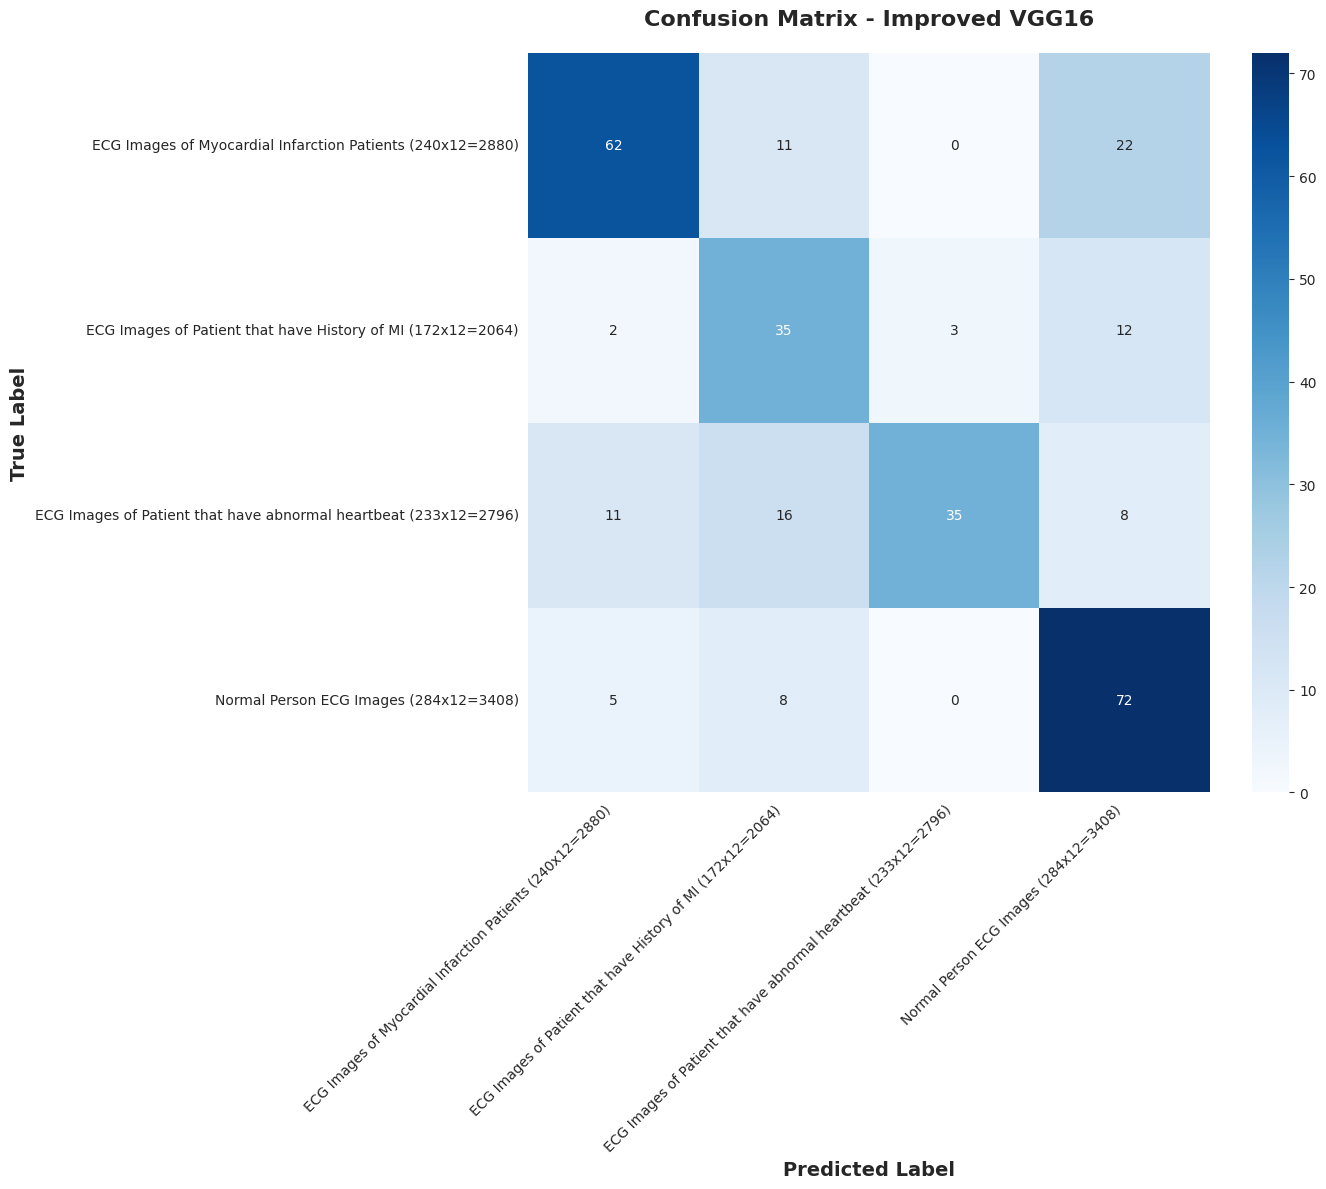


ADDITIONAL METRICS:
Accuracy: 0.6755
Weighted Precision: 0.7211
Weighted Recall: 0.6755
Weighted F1-Score: 0.6756

PER-CLASS ACCURACY ANALYSIS
ECG Images of Myocardial Infarction Patients (240x12=2880):  62/ 95 = 0.6526
ECG Images of Patient that have History of MI (172x12=2064):  35/ 52 = 0.6731
ECG Images of Patient that have abnormal heartbeat (233x12=2796):  35/ 70 = 0.5000
Normal Person ECG Images (284x12=3408):  72/ 85 = 0.8471

Best performing class: Normal Person ECG Images (284x12=3408) (0.8471)
Worst performing class: ECG Images of Patient that have abnormal heartbeat (233x12=2796) (0.5000)

TRAINING HISTORY PLOTS


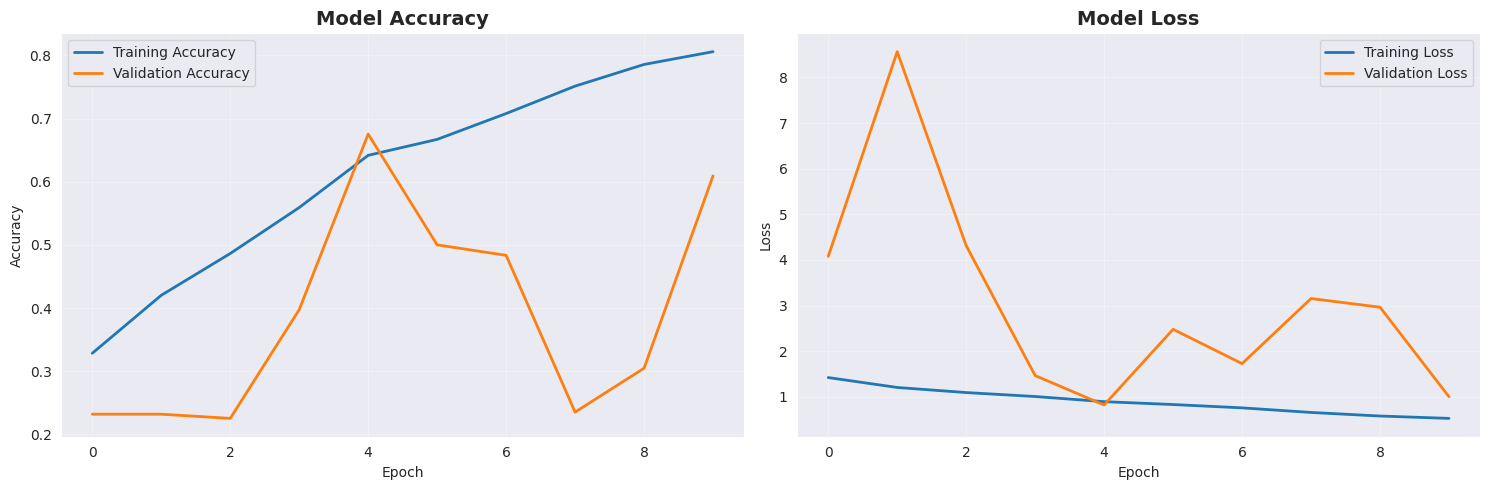


TRAINING SUMMARY
Final Validation Accuracy: 0.6755
Total Epochs Trained: 10
Final Training Accuracy: 0.8060
Final Validation Accuracy: 0.6093
Final Training Loss: 0.5288
Final Validation Loss: 1.0042


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\nGenerating predictions for classification report and confusion matrix...")

y_true = []
y_pred = []

valid_gen.reset()
for i in range(len(valid_gen)):
    X_batch, y_batch = valid_gen[i]
    y_true.extend(np.argmax(y_batch, axis=1))

    batch_pred = model_vgg16_improved.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(batch_pred, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
class_names = list(valid_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={'size': 10})
plt.title('Confusion Matrix - Improved VGG16', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nADDITIONAL METRICS:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

print("\n" + "="*60)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*60)

class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_correct = np.sum((y_pred[class_mask] == i))
        class_total = np.sum(class_mask)
        class_acc = class_correct / class_total
        class_accuracy[class_name] = class_acc
        print(f"{class_name:<20}: {class_correct:>3}/{class_total:>3} = {class_acc:.4f}")

if class_accuracy:
    best_class = max(class_accuracy, key=class_accuracy.get)
    worst_class = min(class_accuracy, key=class_accuracy.get)
    print(f"\nBest performing class: {best_class} ({class_accuracy[best_class]:.4f})")
    print(f"Worst performing class: {worst_class} ({class_accuracy[worst_class]:.4f})")

print("\n" + "="*60)
print("TRAINING HISTORY PLOTS")
print("="*60)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Validation Accuracy: {accuracy_vgg16_improved:.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# VGG19